# Grad-CAM: How to visualize class activation maps to bring Interpretability to Deep Learning

## Setup

In [1]:
# Usual Imports for Deep Learning
import numpy as np
import tensorflow as tf
from tensorflow import keras

# Display
from IPython.display import Image
import matplotlib.pyplot as plt
import matplotlib.cm as cm

In [2]:
# Prepare the model. model_builder() is used to load Xception with Keras
# You can check the documentation of those functions on https://www.tensorflow.org
model_builder = keras.applications.xception.Xception
img_size = (299, 299)
preprocess_input = keras.applications.xception.preprocess_input
decode_predictions = keras.applications.xception.decode_predictions

# Create the model, by using pretrained weights on ImageNet
model = model_builder(weights="imagenet")
# print(model.summary())

91884032/91884032 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


123278/123278 ━━━━━━━━━━━━━━━━━━━━ 0s 4us/step


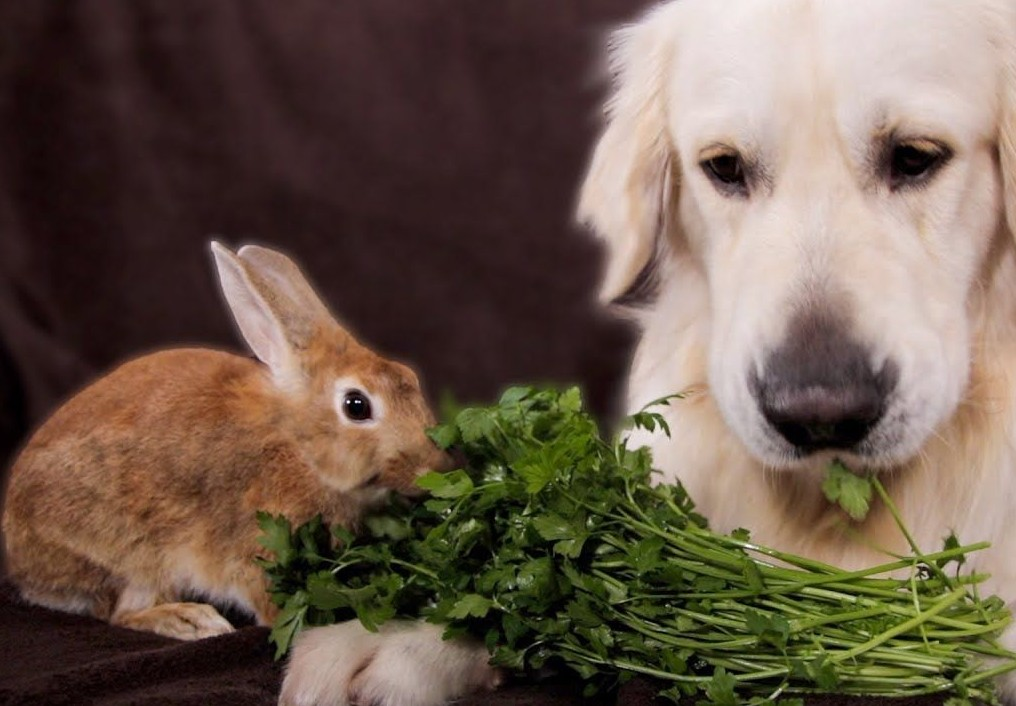

In [3]:
# Isolate the last convolutional layer
last_conv_layer_name = "block14_sepconv2_act"
classifier_layer_names = [
    "avg_pool",
    "predictions",
]

# The local path to our target image
img_path = keras.utils.get_file(
    # "cattwo.jpg", "https://images.ctfassets.net/b85ozb2q358o/33GmKOOKkJBs0ulMT0xlQi/40b62c4ec3627ce77099ce7b2c7f8780/cohabitation_deux_chats_4_240682884.jpeg"
    # "cat_two.jpg", "https://spaestrie.qc.ca/wp-content/uploads/2020/11/Rencontre_chat_chat-e1606755509607.png"
    # "cat_rabbit.jpg", "https://image.vovworld.vn/w500/Uploaded/vovworld/eslysasfzyr/2023_02_01/meo-tho-1123_XXLO.jpg"
    "chien_lapin.jpg", "https://blog.cuisine-a-crocs.com/wp-content/uploads/2013/08/viande-de-lapin-pour-un-chien.jpg"
)

# Visualize the image
display(Image(img_path))

## The Grad-CAM algorithm

In [4]:
def get_img_array(img_path, size):
    # `img` is a PIL image of size 299x299
    img = keras.preprocessing.image.load_img(img_path, target_size=size)
    # `array` is a float32 Numpy array of shape (299, 299, 3)
    array = keras.preprocessing.image.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size (1, 299, 299, 3). We do this because this dimension is needed for most built-in functions
    array = np.expand_dims(array, axis=0)
    return array


def make_gradcam_heatmap(
    img_array, model, last_conv_layer_name, classifier_layer_names, prediction_rank=1):
    # The variable "prediction_rank" is used to apply gradcam on the top class
    # You can modify it to prediction_rank=n for a heatmap on the nth top class

    # First, we create a model that maps the input image to the activations of the last conv layer
    last_conv_layer = model.get_layer(last_conv_layer_name)
    last_conv_layer_model = keras.Model(model.inputs, last_conv_layer.output)

    # Second, we create a model that maps the activations of the last conv layer to the final class predictions
    classifier_input = keras.Input(shape=last_conv_layer.output.shape[1:])
    x = classifier_input
    for layer_name in classifier_layer_names:
        x = model.get_layer(layer_name)(x)
    classifier_model = keras.Model(classifier_input, x)

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        # GradientTape() is a built-in Tensorflow tool to record operations for automatic differentiation.
        # https://www.tensorflow.org/api_docs/python/tf/GradientTape
        # We compute activations of the last conv layer and make the tape watch it
        last_conv_layer_output = last_conv_layer_model(img_array)
        tape.watch(last_conv_layer_output)
        # Compute class predictions
        # We pass the activations of the last conv in our classifier_model to obtain the predictions of the model
        preds = classifier_model(last_conv_layer_output)
        # This prediction has a shape=(1, 1000) because there is 1000 classes in ImageNet.
        # We find the index of the top prediction and we call it pred_index, because it's the index of the prediction
        pred_index = tf.argsort(preds)[0][-prediction_rank]
        # We only keep the value of the prediction at the position of the pred_index
        top_class_channel = preds[:, pred_index]


    # This is the gradient of the top predicted class with respect to
    # the output feature map of the last conv layer
    grads = tape.gradient(top_class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with respect to the top predicted class
    last_conv_layer_output = last_conv_layer_output.numpy()[0]
    pooled_grads = pooled_grads.numpy()
    for i in range(pooled_grads.shape[-1]):
        last_conv_layer_output[:, :, i] *= pooled_grads[i]

    # The channel-wise mean of the resulting feature map
    # is our heatmap of activation for the top class
    heatmap = np.mean(last_conv_layer_output, axis=-1)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = np.maximum(heatmap, 0) / np.max(heatmap)
    return heatmap

## Let's use it

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
35363/35363 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Top 5 Predictions: [('n02099601', 'golden_retriever', 0.2123942), ('n02111500', 'Great_Pyrenees', 0.0809369), ('n02325366', 'wood_rabbit', 0.07236055), ('n02099712', 'Labrador_retriever', 0.02032651), ('n02104029', 'kuvasz', 0.01868299)]


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(1, 299, 299, 3))
  warnings.warn(msg)


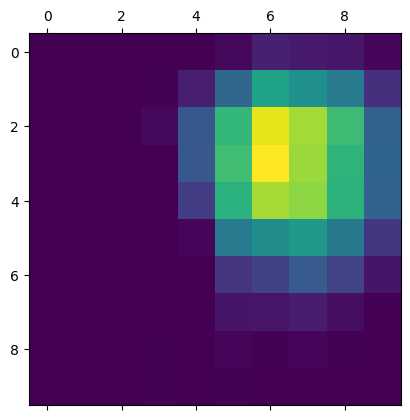

In [5]:
# Prepare image
img_array = preprocess_input(get_img_array(img_path, size=img_size))
preds = model.predict(img_array)

# In order to check the 2nd and 3rd predicted class, we also print the predictions with top=3
print("Top 5 Predictions:", decode_predictions(preds, top=5)[0])

# Generate class activation heatmap
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name, classifier_layer_names, prediction_rank=1)
plt.matshow(heatmap)

plt.show()

## Create a superimposed visualization

Finally, we are going to superimpose this heatmap to the input image in order to easily visualize it

<ipython-input-6-5ca61a271316>:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  jet = cm.get_cmap("jet")


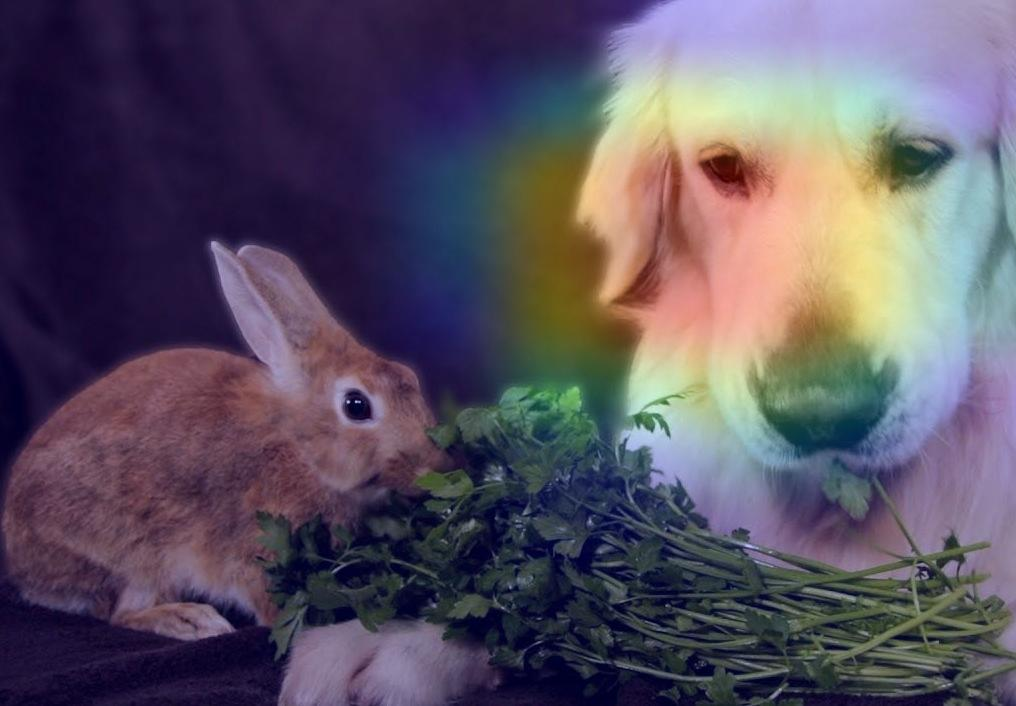

In [6]:
# We load the original image
img = keras.preprocessing.image.load_img(img_path)
img = keras.preprocessing.image.img_to_array(img)

# We rescale heatmap to a range 0-255 (because earlier, for visualization purpose, we normalized the heatmap between 0 & 1)
# We rescale it on this range to have it in RGB, so that we can superimpose it on the rabbit picture.
heatmap = np.uint8(255 * heatmap)

# We use jet colormap to colorize heatmap
jet = cm.get_cmap("jet")

# We use RGB values of the colormap
jet_colors = jet(np.arange(256))[:, :3]
jet_heatmap = jet_colors[heatmap]

# We create an image with RGB colorized heatmap
jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

# Superimpose the heatmap on original image
superimposed_img = jet_heatmap * 0.4 + img #0.4 good value
superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)

# Save the superimposed image
save_path = "rabbit_cam.jpg"
superimposed_img.save(save_path)

# Display Grad CAM
display(Image(save_path))

<ipython-input-7-3ed41a5a6c03>:12: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  jet = cm.get_cmap("jet")


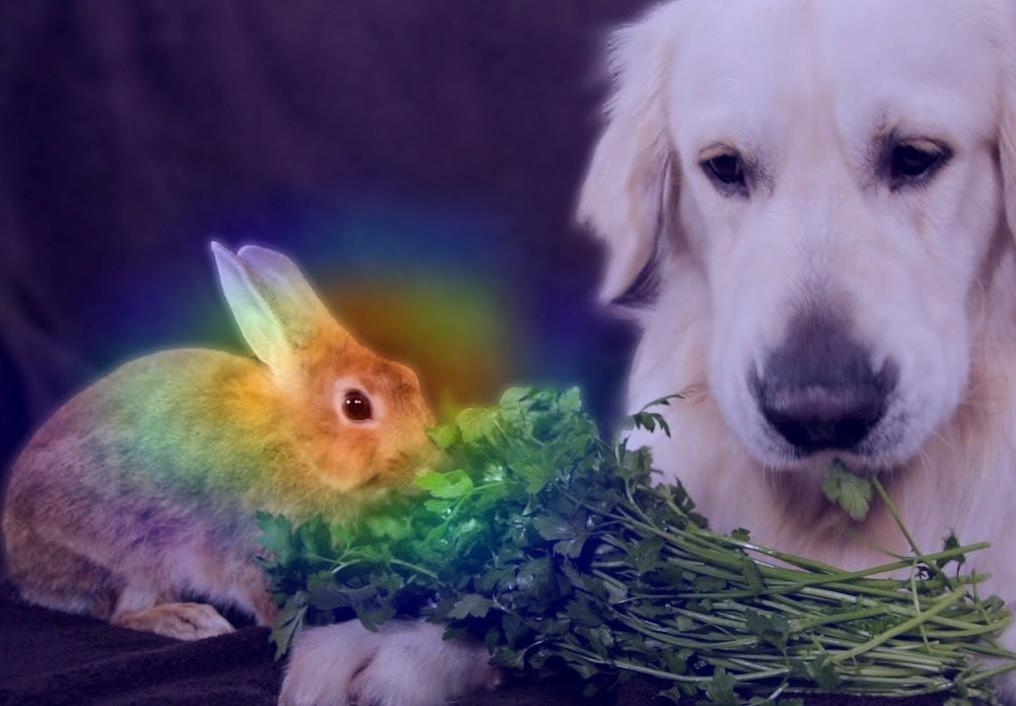

In [7]:
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name, classifier_layer_names, prediction_rank=3)

# We load the original image
img = keras.preprocessing.image.load_img(img_path)
img = keras.preprocessing.image.img_to_array(img)

# We rescale heatmap to a range 0-255 (because earlier, for visualization purpose, we normalized the heatmap between 0 & 1)
# We rescale it on this range to have it in RGB, so that we can superimpose it on the rabbit picture.
heatmap = np.uint8(255 * heatmap)

# We use jet colormap to colorize heatmap
jet = cm.get_cmap("jet")

# We use RGB values of the colormap
jet_colors = jet(np.arange(256))[:, :3]
jet_heatmap = jet_colors[heatmap]

# We create an image with RGB colorized heatmap
jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

# Superimpose the heatmap on original image
superimposed_img = jet_heatmap * 0.4 + img #0.4 good value
superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)

# Save the superimposed image
save_path = "rabbit_cam.jpg"
superimposed_img.save(save_path)

# Display Grad CAM
display(Image(save_path))